In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [2]:
#파이토치 데이터셋 클래스 작성
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
  def __init__(self, review_df, vectorizer):
    """
      매개변수:
        review_df (pandas.DataFrame): 데이터 셋
        vectorizer (ReviewVectorizer): ReviewVectorizer 객체
    """
    #객체 인스턴스 변수 설정
    self.review_df = review_df
    self._vectorizer = vectorizer

    self.train_df = self.review_df[self.review_df.split == "train"]
    self.train_size = len(self.train_df)

    self.val_df = self.review_df[self.review_df.split == "val"]
    self.val_size = len(self.val_df)

    self.test_df = self.review_df[self.review_df.split == "test"]
    self.test_size = len(self.test_df)

    self._lookup_dict = {"train": (self.train_df, self.train_size),
                        "val": (self.val_df, self.val_size),
                        "test": (self.test_df, self.test_size)}
    self.set_split("train")

  @classmethod
  def load_dataset_and_make_vectorizer(cls, review_csv):
    """ 데이터셋을 로드하고 새로운 ReviewVectorizer 객체를 생성함.

    매개변수:
      review_csv(str)
    반환값:
      ReviewDataset의 인스턴스
    """
    review_df = pd.read_csv(review_csv)
    train_review_df = review_df[review_df.split == "train"]
    # ReviewVectorizer.from_dataframe(train_review_df)의 반환값 : ReviewVectorizer의 객체임.
    return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))

  @classmethod
  def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
    review_df = pd.read_csv(review_csv)
    vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
    return cls(review_df, vectorizer)

  @staticmethod
  def load_vectorizer_only(vectorizer_filepath):
    with open(vectorizer_filepath) as fp:
      return ReviewVectorizer.from_serializable(json.load(fp))

  def save_vectorizer(self, vectorizer_filepath):
    with open(vectorizer_filepath, "w") as fp:
      json.dump(self._vectorizer.to_serializable(), fp)

  def get_vectorizer(self):
    return self._vectorizer

  def set_split(self, split="train"):
    self._target_split = split
    self._target_df, self._target_size = self._lookup_dict[split]

  def __len__(self):
    return self._target_size

  def __getitem__(self, index):
    """파이토치 사용자 Dataset에서 구현해야하는 함수 -> __len__, __init__, __getitem__
      매개변수:
        index (int): 데이터 포인트의 인덱스
      반환값:
        데이터 포인트의 특성(x_data)과 레이블(y_target)로 이루어진 딕셔너리
    """
    row = self._target_df.iloc[index]
    review_vector = self._vectorizer.vectorize(row.review)
    rating_index = self._vectorizer.rating_vocab.lookup_token(row.rating)

    return {"x_data": review_vector,
            "y_target": rating_index}

  def get_num_batches(self, batch_size):
    return len(self) // batch_size


In [3]:
class Vocabulary():
  #매핑을 위해 텍스트를 처리하고 어휘 사전을 만듬.

  def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
    """
    매개변수:
      token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
      add_unk (bool): UNK 토큰을 추가할지 지정하는 플래그
      unk_token (str) = Vocabulary에 추가할 UNK토큰
    """

    if token_to_idx is None:
      token_to_idx = {}
      self._token_to_idx = token_to_idx
      self._idx_to_token = {idx: token
                            for token, idx in self._token_to_idx.items()}
      self._add_unk = add_unk
      self._unk_token = unk_token

      self.unk_index = -1
      if add_unk:
        self.unk_index = self.add_token(unk_token)

  def to_serializable(self):
    return {"token_to_idx": self._token_to_idx,
            "add_unk": self._add_unk,
            "unk_token": self._unk_token}

  @classmethod
  def from_serialzable(cls, contents):
    return cls(**contents)

  def add_token(self, token):
    if token in self._token_to_idx:
      index = self._token_to_idx[token]
    else:
      index = len(self._token_to_idx)
      self._token_to_idx[token] = index
      self._idx_to_token[index] = token
    return index

  def lookup_token(self, token):
    """토큰을 인덱스로 바꿔 반환"""
    if self.unk_index >= 0:
      return self._token_to_idx.get(token, self.unk_index)
    else:
      return self._token_to_idx[token]

  def lookup_index(self, index):
    """인덱스에 해당하는 토큰을 반환"""
    if index not in self._idx_to_token:
      raise KeyError("Vocabulary에 인덱스(%d)가 없스비다." % index)
    return self._idx_to_token[index]

  def __str__(self):
    return "<Vocabulary(size=%d)>" & len(self)

  def __len__(self):
    return len(self._token_to_idx)

In [4]:
class ReviewVectorizer():
  """어휘 사전 생성 및 관리"""
  def __init__(self, review_vocab, rating_vocab):
    self.review_vocab = review_vocab
    self.rating_vocab = rating_vocab

  def vectorize(self, review):
    one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
    for token in review.split(" "):
      if token not in string.punctuation:
        one_hot[self.review_vocab.lookup_token(token)] = 1
    return one_hot

  @classmethod
  def from_dataframe(cls, review_df, cutoff=25):
    review_vocab = Vocabulary(add_unk=True)
    rating_vocab = Vocabulary(add_unk=False)

    for rating in sorted(set(review_df.rating)):
      rating_vocab.add_token(rating)

    word_counts = Counter()
    for review in review_df.review:
      for word in review.split(" "):
        if word not in string.punctuation:
          word_counts[word] += 1
    for word, count in word_counts.items():
      if count > cutoff:
        review_vocab.add_token(word)

    return cls(review_vocab, rating_vocab)

  @classmethod
  def from_serializable(cls, contents):
    review_vocab = Vocabulary.from_serializable(contents["review vocab"])
    rating_vocab = Vocabulary.from_serializable(contents["rating_vocab"])

    return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

  def to_serializable(self):
    return {"review_vocab": self.review_vocab.to_serializable(),
            "rating_vocab": self.rating_vocab.to_serializable()}

In [5]:
from torch.utils.data import DataLoader

def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
  dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    #print(out_data_dict)
    yield out_data_dict

In [6]:
import torch.nn as nn

class ReviewClassifier(nn.Module):
  def __init__(self, num_features):
    super(ReviewClassifier, self).__init__()
    self.fc1 = nn.Linear(in_features=num_features,
                         out_features=1)

  def forward(self, x_in, apply_sigmoid=False):
    y_out = self.fc1(x_in).squeeze()
    if apply_sigmoid:
      y_out = torch.sigmoid(y_out)
    return y_out

In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [8]:
from argparse import Namespace
base_path = "/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter3_Basic_NeuralNet/data/yelp/"
args = Namespace(
    frequent_cutoff = 25,
    model_state_file = "model.pth",
    review_csv=base_path + "reviews_with_splits_lite.csv",
    save_dir = base_path + "model_storage/ch3/yelp/",
    vectorizer_file = "vectorizer.json",
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate = 1e-3,
    num_epochs=100,
    seed=1337,
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

print("CUDA 사용여부: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter3_Basic_NeuralNet/data/yelp/model_storage/ch3/yelp/vectorizer.json
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter3_Basic_NeuralNet/data/yelp/model_storage/ch3/yelp/model.pth
CUDA 사용여부: True


In [9]:
def make_train_state(args):
  return {
      "stop_early": False,
      "early_stopping_step": 0,
      "early_stopping_best_val":1e8,
      "learning_rate": args.learning_rate,
      "epoch_index": 0,
      "train_loss": [],
      "train_acc": [],
      "val_loss": [],
      "val_acc": [],
      "test_loss": -1,
      "test_acc": -1,
      "model_filename": args.model_state_file
  }

def update_train_state(args, model, train_state):
    """ 훈련 상태를 업데이트합니다.

    Components:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            train_state['early_stopping_step'] = 0

        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [10]:
if args.reload_from_files:
  print("데이터셋과 Vectorizer를 로드합니다")
  dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv, args.vectorizer_file)
else:
  print("데이터셋 로드, Vectorizer 생성")
  dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
  dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))
classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5,
                                                 patience = 1)
train_state = make_train_state(args)

데이터셋 로드, Vectorizer 생성


In [11]:
epoch_bar = tqdm.notebook.tqdm(desc="training routine",
                               total=args.num_epochs,
                               position=0)
dataset.set_split("train")
train_bar = tqdm.notebook.tqdm(desc="split=train",
                               total=dataset.get_num_batches(args.batch_size),
                               position=1,
                               leave=True)
dataset.set_split("val")
val_bar = tqdm.notebook.tqdm(desc="split=val",
                             total=dataset.get_num_batches(args.batch_size),
                             position=1,
                             leave=True)


for epoch_index in range(args.num_epochs):
  train_state["epoch_index"] = epoch_index

  dataset.set_split("train")
  batch_generator = generate_batches(dataset,
                                      batch_size=args.batch_size,
                                      device=args.device)
  running_loss = 0.0
  running_acc= 0.0
  classifier.train()
  for batch_index, batch_dict in enumerate(batch_generator):
    optimizer.zero_grad()

    y_pred = classifier(x_in=batch_dict["x_data"].float())

    loss = loss_func(y_pred, batch_dict["y_target"].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    loss.backward()
    optimizer.step()

    acc_t = compute_accuracy(y_pred, batch_dict["y_target"])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_bar.set_postfix(loss=running_loss,
                          acc=running_acc,
                          epoch=epoch_index)
    train_bar.update()

  train_state["train_loss"].append(running_loss)
  train_state["train_acc"].append(running_acc)

  dataset.set_split("val")
  batch_generator = generate_batches(dataset, batch_size=args.batch_size,
                                      device = args.device)

  running_loss = 0.
  running_acc = 0.
  classifier.eval()

  for batch_index, batch_dict in enumerate(batch_generator):

    # 단계 1. 출력을 계산합니다
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # 단계 2. 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 단계 3. 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

    val_bar.set_postfix(loss=running_loss,
                        acc=running_acc,
                        epoch=epoch_index)
    val_bar.update()

  train_state['val_loss'].append(running_loss)
  train_state['val_acc'].append(running_acc)

  train_state = update_train_state(args=args, model=classifier,
                                    train_state=train_state)

  scheduler.step(train_state['val_loss'][-1])

  train_bar.n = 0
  val_bar.n = 0
  epoch_bar.update()

  if train_state['stop_early']:
      break

  train_bar.n = 0
  val_bar.n = 0
  epoch_bar.update()

  ## 실행에 걸린시간 19분 42초
  ## T4GPU이용

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/306 [00:00<?, ?it/s]

split=val:   0%|          | 0/65 [00:00<?, ?it/s]

In [12]:

# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [13]:
print("테스트 손실: {:.3f}".format(train_state['test_loss']))
print("테스트 정확도: {:.2f}".format(train_state['test_acc']))

테스트 손실: 0.214
테스트 정확도: 91.81


In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [15]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    """ 리뷰 점수 예측하기

    매개변수:
        review (str): 리뷰 텍스트
        classifier (ReviewClassifier): 훈련된 모델
        vectorizer (ReviewVectorizer): Vectorizer 객체
        decision_threshold (float): 클래스를 나눌 결정 경계
    """
    review = preprocess_text(review)

    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))

    probability_value = torch.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

In [16]:
test_review = "this is a pretty awesome book"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

this is a pretty awesome book -> positive


In [17]:
classifier.fc1.weight.shape

torch.Size([1, 7326])

In [30]:

# 가중치 정렬
fc1_weights = classifier.fc1.weight.detach()[0]
sorted_weights, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

# 긍정적인 상위 20개 단어
print("긍정 리뷰에 영향을 미치는 단어:")
print("--------------------------------------")
for i in range(20):
  print(sorted_weights[i], end=" ")
  print(vectorizer.review_vocab.lookup_index(indices[i]))


print("====\n\n\n")

# 부정적인 상위 20개 단어
print("부정 리뷰에 영향을 미치는 단어:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(sorted_weights[-(i+1)], end=" ")
    print(vectorizer.review_vocab.lookup_index(indices[i]))

#퍼셉트론 연산은 결국 원핫 벡터와 가중치 행렬의 내적과 동일하다.
#delicious는 sigomid의 x값을 오른쪽으로 1.5970만큼 당긴다.
#worst는 sigmoid의 x값을 왼쪽으로 -1.9905만큼당긴다.

긍정 리뷰에 영향을 미치는 단어:
--------------------------------------
tensor(1.5970) delicious
tensor(1.4344) fantastic
tensor(1.3780) pleasantly
tensor(1.3765) amazing
tensor(1.2922) great
tensor(1.2792) vegas
tensor(1.2320) excellent
tensor(1.2278) yum
tensor(1.2030) perfect
tensor(1.2017) awesome
tensor(1.1826) ngreat
tensor(1.1708) yummy
tensor(1.1288) love
tensor(1.0801) bomb
tensor(1.0564) solid
tensor(1.0254) pleased
tensor(1.0226) wonderful
tensor(1.0133) chinatown
tensor(1.0116) notch
tensor(0.9908) deliciousness
====



부정 리뷰에 영향을 미치는 단어:
--------------------------------------
tensor(-1.9905) worst
tensor(-1.8154) mediocre
tensor(-1.7391) bland
tensor(-1.6600) horrible
tensor(-1.6120) meh
tensor(-1.5905) awful
tensor(-1.5662) rude
tensor(-1.5343) terrible
tensor(-1.3868) tasteless
tensor(-1.3507) overpriced
tensor(-1.3024) disgusting
tensor(-1.2454) unacceptable
tensor(-1.2451) poorly
tensor(-1.2291) slowest
tensor(-1.2248) unfriendly
tensor(-1.1996) nmaybe
tensor(-1.1681) disappointing


-0.0059629683
1.5969505
-1.9905225


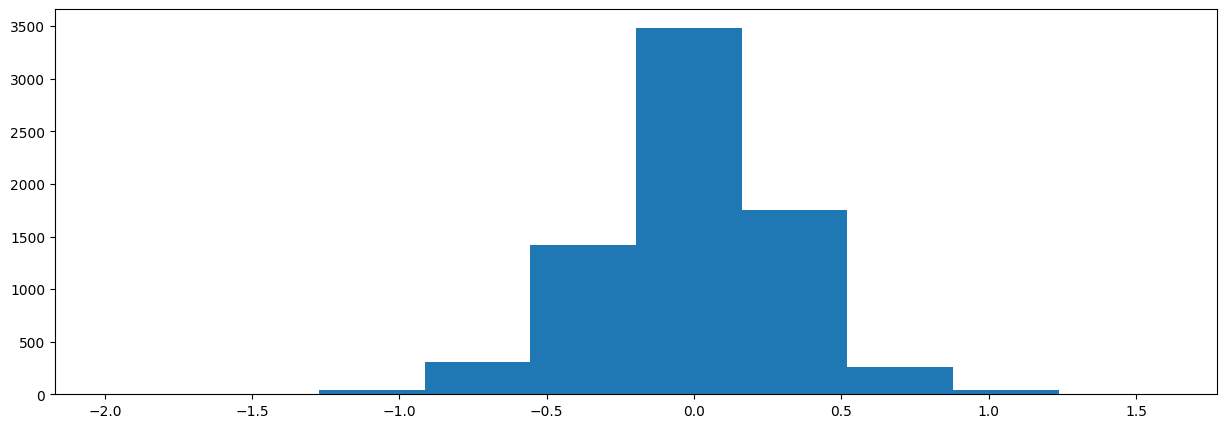

In [31]:
import matplotlib.pyplot as plt

fc1_weights = fc1_weights.numpy()

print(np.mean(fc1_weights))
print(np.max(fc1_weights))
print(np.min(fc1_weights))

plt.figure(figsize=(15, 5))
plt.hist(fc1_weights)
plt.show()

<Figure size 640x480 with 0 Axes>

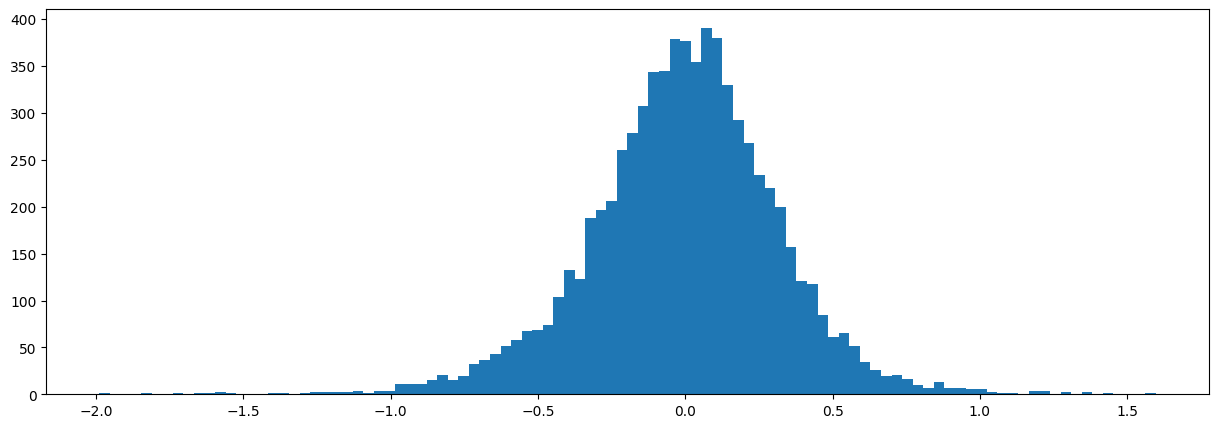

In [32]:
plt.clf()
plt.figure(figsize=(15, 5))
plt.hist(fc1_weights, bins=100)
plt.show()
#대부분의 단어들이 0에 가까운 값을 가지고, 분포형태가 대칭인것 또한 확인할 수 있다.